In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

In [2]:
df = pd.read_csv("consolidated.csv", encoding='latin1')
df.head()

,CustomerID,ProductID,TransactionID,PurchaseAmount,PurchaseDate,PurchaseTime,PurchaseQuantity,CustomerName,Gender,Adress,...,Number,RegistrationDate,CategoryID,Categories,Products,Prices,StockQuantity,FeedbackID,FeedbackDate,Ratings
0,CUSTIDXX-62149,PRODOXIID94,0,294,20-06-2023,2025-01-30T15:56:00.000Z,2,Kayla Torres,M,141 Nicole Circles Apt. 507,...,413-262-9473,28-10-2021,CATOID00XX10,Pasta Rice and Grains,Lentils,1.30,75,FEDBXXID-0,12-03-2018,3
1,CUSTIDXX-45943,PRODOXIID22,1,125,03-09-2019,2025-01-30T14:40:00.000Z,10,Brian Weiss,F,2510 Robert Garden Apt. 316,...,786.640.2568x939,16-01-2024,CATOID00XX3,Meat and Seafood,Pork,6.00,1,FEDBXXID-1,26-09-2023,5
2,CUSTIDXX-52617,PRODOXIID42,2,828,26-08-2017,2025-01-30T12:34:00.000Z,7,Samantha Wagner,F,973 Perez Pass Suite 421,...,001-819-914-9252x34806,29-09-2022,CATOID00XX5,Frozen Foods,Frozen Meals,15.00,30,FEDBXXID-2,17-10-2022,5
3,CUSTIDXX-2768,PRODOXIID64,3,566,25-01-2023,2025-01-30T00:54:00.000Z,22,Karen Wise,F,87415 Hill Plaza,...,421.232.6359x04551,21-04-2017,CATOID00XX7,Snacks and Beverages,Nuts,8.98,53,FEDBXXID-3,05-12-2019,5
4,CUSTIDXX-4036,PRODOXIID104,4,790,19-04-2023,2025-01-30T04:10:00.000Z,16,Tiffany Glover,M,67551 Pamela Rest Apt. 216,...,505-592-3515,18-01-2018,CATOID00XX11,Baking Supplies,Vanilla Extract,1.29,52,FEDBXXID-4,16-04-2022,1


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99653 entries, 0 to 99652
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerID        99653 non-null  object 
 1   ProductID         99653 non-null  object 
 2   TransactionID     99653 non-null  int64  
 3   PurchaseAmount    99653 non-null  int64  
 4   PurchaseDate      99653 non-null  object 
 5   PurchaseTime      99653 non-null  object 
 6   PurchaseQuantity  99653 non-null  int64  
 7   CustomerName      99653 non-null  object 
 8   Gender            99653 non-null  object 
 9   Adress            99653 non-null  object 
 10  Email             99653 non-null  object 
 11  Number            99653 non-null  object 
 12  RegistrationDate  99653 non-null  object 
 13  CategoryID        99653 non-null  object 
 14  Categories        99653 non-null  object 
 15  Products          99653 non-null  object 
 16  Prices            99653 non-null  float6

In [4]:
# Convert Purchase Date to datetime format
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate']).dt.date

C:\Users\bsaim\AppData\Local\Temp\ipykernel_8900\1264166246.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate']).dt.date


In [5]:
# Define the latest purchase date for recency calculation
Recent_date = df['PurchaseDate'].max()
print(Recent_date)

2024-03-22


**Simple Quartile Method**

In [6]:
# Calculate RFM Metrics
rfm_sqm = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (Recent_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency (Unique Orders)
    'PurchaseAmount': 'sum'  # Monetary (Total Spending)
}).reset_index()

rfm_sqm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_sqm.head()

,CustomerID,Recency,Frequency,Monetary
0,CUSTIDXX-0,78,3,2991
1,CUSTIDXX-1,2024,1,32
2,CUSTIDXX-10,522,2,1925
3,CUSTIDXX-100,235,4,4581
4,CUSTIDXX-10000,504,2,2313


In [7]:
# Apply Quartile-based segmentation
rfm_sqm['R_Score'] = pd.qcut(rfm_sqm['Recency'].rank(method='first'), 4,[4, 3, 2, 1])
rfm_sqm['F_Score'] = pd.qcut(rfm_sqm['Frequency'].rank(method='first'), 4, [1, 2, 3, 4])
rfm_sqm['M_Score'] = pd.qcut(rfm_sqm['Monetary'].rank(method='first'), 4, [1, 2, 3, 4])
rfm_sqm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,CUSTIDXX-0,78,3,2991,4,4,4
1,CUSTIDXX-1,2024,1,32,1,1,1
2,CUSTIDXX-10,522,2,1925,3,2,3
3,CUSTIDXX-100,235,4,4581,4,4,4
4,CUSTIDXX-10000,504,2,2313,3,2,4


In [8]:
# Select the RFM Scores for Clustering
rfm_sqm_cluster = rfm_sqm[['R_Score', 'F_Score', 'M_Score']]

# Normalize Data (Standard Scaling is necessary for K-Means)
scaler = StandardScaler()
rfm_sqm_scaled = scaler.fit_transform(rfm_sqm_cluster)

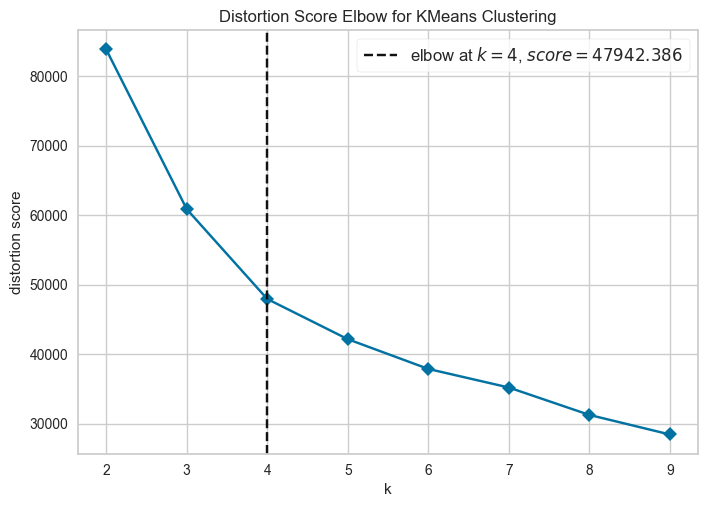

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# Find Optimal K Using Elbow Method
model = KMeans(init="k-means++", random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
visualizer.fit(rfm_sqm_scaled)  # Fit the data
visualizer.show()

In [10]:
# Select the Optimal K (Based on Elbow Point)
optimal_k_sqm = visualizer.elbow_value_
print(f"Optimal Number of Clusters: {optimal_k_sqm}")

Optimal Number of Clusters: 4


In [11]:
# Apply K-Means with Optimal K
kmeans = KMeans(n_clusters=optimal_k_sqm, random_state=42)
rfm_sqm['Cluster'] = kmeans.fit_predict(rfm_sqm_scaled)

In [12]:
# Evaluate Clustering Performance
print(f"\033[4mEvaluation Metrics for SQM with K={optimal_k_sqm}:\033[0m")
silhouette_avg_sqm = silhouette_score(rfm_sqm_scaled, rfm_sqm['Cluster'])
print(f"Silhouette Score : {silhouette_avg_sqm:.4f}")

from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
#Compute WCSS (Within-Cluster Sum of Squares)
WCSS_sqm = kmeans.inertia_
print(f"WCSS: {WCSS_sqm:.4f}")

#Compute Davies-Bouldin Index (DBI)
dbi_sqm = davies_bouldin_score(rfm_sqm_scaled, rfm_sqm['Cluster'])
print(f"Davies-Bouldin Index : {dbi_sqm:.4f} ")

#Compute Calinski-Harabasz Index (CHI)
chi_sqm = calinski_harabasz_score(rfm_sqm_scaled, rfm_sqm['Cluster'])
print(f"Calinski-Harabasz Index : {chi_sqm:.4f} ")

Evaluation Metrics for SQM with K=4:
Silhouette Score : 0.3762
WCSS: 47942.3857
Davies-Bouldin Index : 0.9972 
Calinski-Harabasz Index : 40972.1145 


In [13]:
# Group by clusters and calculate the mean RFM values for each cluster
cluster_means_sqm = rfm_sqm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Mean RFM values for each cluster of SQM:")
print(cluster_means_sqm)

Mean RFM values for each cluster of SQM:
   Cluster      Recency  Frequency     Monetary
0        0   412.857203   1.335508   873.714153
1        1   451.579395   2.946647  2564.487959
2        2  1688.801967   1.065202   746.277540
3        3  1458.698189   2.043672  1762.675297


In [14]:
# Define dynamic thresholds for segmentation
recency_threshold = rfm_sqm['Recency'].median()   
frequency_threshold = rfm_sqm['Frequency'].median()  
monetary_threshold = rfm_sqm['Monetary'].median()  

In [15]:
# Assign segment labels based on cluster characteristics
def assign_cluster_label(cluster_id):
    recency = cluster_means_sqm.loc[cluster_means_sqm['Cluster'] == cluster_id, 'Recency'].values[0]
    frequency = cluster_means_sqm.loc[cluster_means_sqm['Cluster'] == cluster_id, 'Frequency'].values[0]
    monetary = cluster_means_sqm.loc[cluster_means_sqm['Cluster'] == cluster_id, 'Monetary'].values[0]
# Define dynamic segment rules
    if recency < recency_threshold and frequency > frequency_threshold and monetary > monetary_threshold:
        return "Best Customers"  # Recent, frequent, high spenders
    elif recency > recency_threshold and frequency < frequency_threshold and monetary < monetary_threshold:
        return "Dormant Customers"  # Long inactive, low frequency, low spenders
    elif recency < recency_threshold and frequency > frequency_threshold and monetary < monetary_threshold:
        return "Frequent Low-Spending"  # Recent and frequent, but low spending
    else:
        return "At-Risk Customers"  # Moderate or inactive customers

In [16]:
# Map the cluster labels dynamically
cluster_labels = {cluster: assign_cluster_label(cluster) for cluster in rfm_sqm['Cluster'].unique()}
rfm_sqm['Customer_Segment'] = rfm_sqm['Cluster'].map(cluster_labels)

# Display the assigned labels
print("\033[4mSimple Quartile Method Clustering\033[0m")
print(rfm_sqm[['Cluster', 'Customer_Segment']].drop_duplicates())

Simple Quartile Method Clustering
   Cluster   Customer_Segment
0        1     Best Customers
1        2  Dormant Customers
2        0  At-Risk Customers
5        3  At-Risk Customers


**Separate R, F, M Analysis (Tertiary Segmentation)**

In [17]:
rfm_ts = df.copy()
# Calculate RFM Metrics
rfm_ts = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (Recent_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency (Unique Orders)
    'PurchaseAmount': 'sum'  # Monetary (Total Spending)
}).reset_index()

rfm_ts.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_ts.head()

,CustomerID,Recency,Frequency,Monetary
0,CUSTIDXX-0,78,3,2991
1,CUSTIDXX-1,2024,1,32
2,CUSTIDXX-10,522,2,1925
3,CUSTIDXX-100,235,4,4581
4,CUSTIDXX-10000,504,2,2313


In [18]:
recency_median = rfm_ts['Recency'].median()
frequency_median = rfm_ts['Frequency'].median()
monetary_median = rfm_ts['Monetary'].median()

rfm_ts['R_Score'] = rfm_ts['Recency'].apply(lambda x: 1 if x > recency_median else 2)
rfm_ts['F_Score'] = rfm_ts['Frequency'].apply(lambda x: 2 if x > frequency_median else 1)
rfm_ts['M_Score'] = rfm_ts['Monetary'].apply(lambda x: 2 if x > monetary_median else 1)
rfm_ts.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,CUSTIDXX-0,78,3,2991,2,2,2
1,CUSTIDXX-1,2024,1,32,1,1,1
2,CUSTIDXX-10,522,2,1925,2,1,2
3,CUSTIDXX-100,235,4,4581,2,2,2
4,CUSTIDXX-10000,504,2,2313,2,1,2


In [19]:
# Select the RFM Scores for Clustering
rfm_ts_cluster = rfm_ts[['R_Score', 'F_Score', 'M_Score']]

# Normalize Data (Standard Scaling is necessary for K-Means)
scaler = StandardScaler()
rfm_ts_scaled = scaler.fit_transform(rfm_ts_cluster)

c:\Users\bsaim\New folder\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (9). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


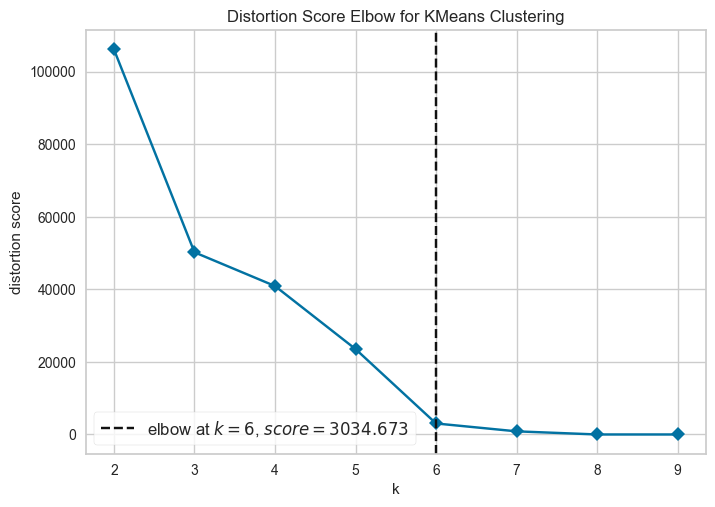

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Find Optimal K Using Elbow Method
model2 = KMeans(init="k-means++", random_state=42)
visualizer2 = KElbowVisualizer(model2, k=(2,10), metric='distortion', timings=False)
visualizer2.fit(rfm_ts_scaled)  # Fit the data
visualizer2.show()

In [21]:
# Select the Optimal K (Based on Elbow Point)
optimal_k_ts = visualizer2.elbow_value_
print(f"Optimal Number of Clusters : {optimal_k_ts}")

Optimal Number of Clusters : 6


In [22]:
# Apply K-Means with Optimal K
kmeans2 = KMeans(n_clusters=optimal_k_ts, random_state=42)
rfm_ts['Cluster'] = kmeans2.fit_predict(rfm_ts_scaled)

In [23]:
# Evaluate Clustering Performance
print(f"\033[4mEvaluation Metrics for TS with K={optimal_k_ts}:\033[0m")
silhouette_avg_ts = silhouette_score(rfm_ts_scaled, rfm_ts['Cluster'])
print(f"Silhouette Score for K={optimal_k_ts}: {silhouette_avg_ts:.4f}")

# Compute WCSS (Within-Cluster Sum of Squares)
WCSS_ts = kmeans.inertia_
print(f"WCSS: {WCSS_ts:.4f}")

# Compute Davies-Bouldin Index (DBI)
dbi_ts = davies_bouldin_score(rfm_ts_scaled, rfm_ts['Cluster'])
print(f"Davies-Bouldin Index : {dbi_ts:.4f} ")

# Compute Calinski-Harabasz Index (CHI)
chi_ts = calinski_harabasz_score(rfm_ts_scaled, rfm_ts['Cluster'])
print(f"Calinski-Harabasz Index : {chi_ts:.4f} ")

Evaluation Metrics for TS with K=6:
Silhouette Score for K=6: 0.9741
WCSS: 47942.3857
Davies-Bouldin Index : 0.1512 
Calinski-Harabasz Index : 545279.9516 


In [24]:
# Group by clusters and calculate the mean RFM values for each cluster
cluster_means_ts = rfm_ts.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Mean RFM values for each cluster for TS:")
print(cluster_means_ts)

Mean RFM values for each cluster for TS:
   Cluster      Recency  Frequency     Monetary
0        0   414.493268   1.333601   752.288284
1        1  1255.536802   3.284898  2630.260152
2        2  1659.687556   1.163365   709.865143
3        3   352.210770   3.499661  2825.699594
4        4   395.339473   1.829031  1893.270852
5        5  1516.642913   1.657113  1809.900342


In [25]:
# Define dynamic thresholds for segmentation for TS
recency_threshold2 = rfm_ts['Recency'].median()  
frequency_threshold2 = rfm_ts['Frequency'].median()  
monetary_threshold2 = rfm_ts['Monetary'].median()  

# Assign segment labels based on cluster characteristics (for rfm2)
def assign_cluster_label_tertiary(cluster_id):
    recency = cluster_means_ts.loc[cluster_means_ts['Cluster'] == cluster_id, 'Recency'].values[0]
    frequency = cluster_means_ts.loc[cluster_means_ts['Cluster'] == cluster_id, 'Frequency'].values[0]
    monetary = cluster_means_ts.loc[cluster_means_ts['Cluster'] == cluster_id, 'Monetary'].values[0]
    
    # Define dynamic segment rules
    if recency < recency_threshold2 and frequency > frequency_threshold2 and monetary > monetary_threshold2:
        return "Best Customers"  # Recent, frequent, high spenders
    elif recency > recency_threshold2 and frequency < frequency_threshold2 and monetary < monetary_threshold2:
        return "Dormant Customers"  # Long inactive, low frequency, low spenders
    elif recency < recency_threshold2 and frequency > frequency_threshold2 and monetary < monetary_threshold2:
        return "Frequent Low-Spending"  # Recent and frequent, but low spending
    else:
        return "At-Risk Customers"  # Moderate or inactive customers

In [26]:
# Map the cluster labels dynamically for rfm2
cluster_labels2 = {cluster: assign_cluster_label_tertiary(cluster) for cluster in rfm_ts['Cluster'].unique()}
rfm_ts['Customer_Segment'] = rfm_ts['Cluster'].map(cluster_labels2)

# Display the assigned labels
print("\033[4mTeritiry Segmentation Clustering\033[0m")
print(rfm_ts[['Cluster', 'Customer_Segment']].drop_duplicates())

Teritiry Segmentation Clustering
    Cluster   Customer_Segment
0         3     Best Customers
1         2  Dormant Customers
2         4  At-Risk Customers
5         5  At-Risk Customers
14        1  At-Risk Customers
21        0  At-Risk Customers


**Rank & Normalization**

Z-score normalization

In [27]:
rfm_z = df.copy()
# Calculate RFM Metrics
rfm_z = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (Recent_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency (Unique Orders)
    'PurchaseAmount': 'sum'  # Monetary (Total Spending)
}).reset_index()

rfm_z.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_z.head()

,CustomerID,Recency,Frequency,Monetary
0,CUSTIDXX-0,78,3,2991
1,CUSTIDXX-1,2024,1,32
2,CUSTIDXX-10,522,2,1925
3,CUSTIDXX-100,235,4,4581
4,CUSTIDXX-10000,504,2,2313


In [28]:
# Normalize the RFM values using Z-score normalization
scaler = StandardScaler()
rfm_z[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_z[['Recency', 'Frequency', 'Monetary']])

# Rank the customers based on the normalized values
rfm_z['R_Score'] = rfm_z['Recency'].rank(ascending=True)  # Lower Recency = better customer
rfm_z['F_Score'] = rfm_z['Frequency'].rank(ascending=False)  # Higher Frequency = better customer
rfm_z['M_Score'] = rfm_z['Monetary'].rank(ascending=False)  # Higher Monetary = better customer

# Calculate the final RFM score by summing the ranks
rfm_z['RFM_Score'] = rfm_z['R_Score'] + rfm_z['F_Score'] + rfm_z['M_Score']

# Sort the customers based on the final score (higher score means better customers)
rfm_z = rfm_z.sort_values(by='RFM_Score', ascending=False)

# Display the final RFM score and customer ranks
print(rfm_z[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())


        Recency  Frequency  Monetary  R_Score  F_Score  M_Score  RFM_Score
48893  2.219121  -0.868023 -1.452970  52871.5  41160.0  52954.5   146986.0
46139  2.220542  -0.868023 -1.451034  52886.5  41160.0  52929.0   146975.5
22554  2.186440  -0.868023 -1.457809  52639.0  41160.0  53021.5   146820.5
15681  2.206333  -0.868023 -1.446195  52772.0  41160.0  52847.5   146779.5
47496  2.214858  -0.868023 -1.441356  52835.5  41160.0  52773.0   146768.5


In [29]:
# Select the RFM Scores for Clustering
rfm_z_cluster = rfm_z[['R_Score', 'F_Score', 'M_Score']]

# Normalize Data (Standard Scaling is necessary for K-Means)
scaler = StandardScaler()
rfm_z_scaled = scaler.fit_transform(rfm_z_cluster)

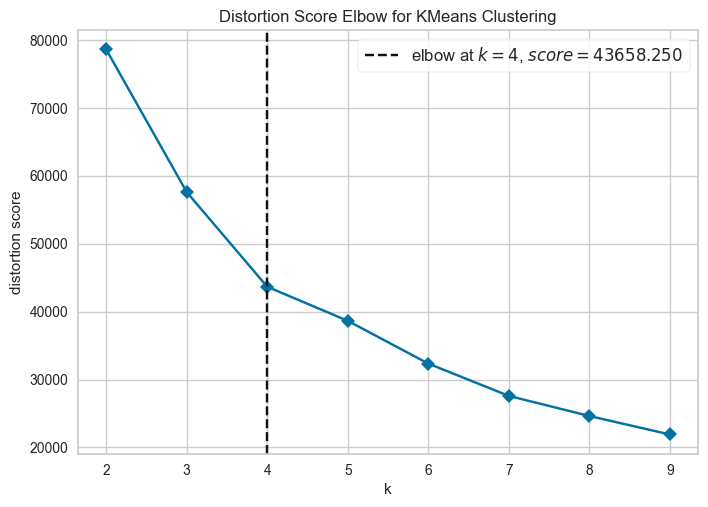

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
# Find Optimal K Using Elbow Method
model = KMeans(init="k-means++", random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(rfm_z_scaled)  # Fit the data
visualizer.show()

In [31]:
# Select the Optimal K (Based on Elbow Point)
optimal_k_z = visualizer.elbow_value_
print(f"Optimal Number of Clusters : {optimal_k_z}")

Optimal Number of Clusters : 4


In [32]:
# Apply K-Means with Optimal K
kmeans = KMeans(n_clusters=optimal_k_z, random_state=42)
rfm_z['Cluster'] = kmeans.fit_predict(rfm_z_scaled)

In [33]:
# Evaluate Clustering Performance
print(f"\033[4mEvaluation Metrics for Z with K={optimal_k_z}:\033[0m")
silhouette_avg_z = silhouette_score(rfm_z_scaled, rfm_z['Cluster'])
print(f"Silhouette Score for K={optimal_k_z} : {silhouette_avg_z:.4f}")

# Compute WCSS (Within-Cluster Sum of Squares)
WCSS_z = kmeans.inertia_
print(f"WCSS : {WCSS_z:.4f}")

# Compute Davies-Bouldin Index (DBI)
dbi_z = davies_bouldin_score(rfm_z_scaled, rfm_z['Cluster'])
print(f"Davies-Bouldin Index : {dbi_z:.4f} ")

# Compute Calinski-Harabasz Index (CHI)
chi_z = calinski_harabasz_score(rfm_z_scaled, rfm_z['Cluster'])
print(f"Calinski-Harabasz Index : {chi_z:.4f}")

Evaluation Metrics for Z with K=4:
Silhouette Score for K=4 : 0.3751
WCSS : 43658.5778
Davies-Bouldin Index : 1.0150 
Calinski-Harabasz Index : 46727.0248


In [34]:
# Group by clusters and calculate the mean RFM values for each cluster
cluster_means_z = rfm_z.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Mean RFM values for each cluster Z:")
print(cluster_means_z)

Mean RFM values for each cluster Z:
   Cluster   Recency  Frequency  Monetary
0        0  0.394481   0.464716  0.459379
1        1 -0.758005  -0.588249 -0.683697
2        2  1.069020  -0.812703 -0.696199
3        3 -0.923888   1.066721  1.016346


In [35]:
# Define dynamic thresholds for segmentation (for rfm3z)
recency_threshold = rfm_z['Recency'].median()
frequency_threshold = rfm_z['Frequency'].median()
monetary_threshold = rfm_z['Monetary'].median()

# Assign segment labels based on cluster characteristics (for rfm3z)
def assign_cluster_label_zscore(cluster_id):
    recency = cluster_means_z.loc[cluster_means_z['Cluster'] == cluster_id, 'Recency'].values[0]
    frequency = cluster_means_z.loc[cluster_means_z['Cluster'] == cluster_id, 'Frequency'].values[0]
    monetary = cluster_means_z.loc[cluster_means_z['Cluster'] == cluster_id, 'Monetary'].values[0]
    
    # Define dynamic segment rules
    if recency < recency_threshold and frequency > frequency_threshold and monetary > monetary_threshold:
        return "Best Customers"
    elif recency > recency_threshold and frequency < frequency_threshold and monetary < monetary_threshold:
        return "Dormant Customers"
    elif recency < recency_threshold and frequency > frequency_threshold and monetary < monetary_threshold:
        return "Frequent Low-Spending"
    else:
        return "At-Risk Customers"

In [36]:
# Map the cluster labels dynamically for rfm3z
cluster_labels_3 = {cluster: assign_cluster_label_zscore(cluster) for cluster in rfm_z['Cluster'].unique()}
rfm_z['Customer_Segment'] = rfm_z['Cluster'].map(cluster_labels_3)

# Display the assigned labels
print("\033[4mZ-Score Normalization Clustering\033[0m")
print(rfm_z[['Cluster', 'Customer_Segment']].drop_duplicates())


Z-Score Normalization Clustering
       Cluster   Customer_Segment
48893        2  Dormant Customers
23104        1  At-Risk Customers
4622         0  At-Risk Customers
246          3     Best Customers


Min-Max scaling

In [37]:
rfm_m = df.copy()
# Calculate RFM Metrics
rfm_m = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (Recent_date - x.max()).days,  # Recency
    'TransactionID': 'nunique',  # Frequency (Unique Orders)
    'PurchaseAmount': 'sum'  # Monetary (Total Spending)
}).reset_index()

rfm_m.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_m.head()

,CustomerID,Recency,Frequency,Monetary
0,CUSTIDXX-0,78,3,2991
1,CUSTIDXX-1,2024,1,32
2,CUSTIDXX-10,522,2,1925
3,CUSTIDXX-100,235,4,4581
4,CUSTIDXX-10000,504,2,2313


In [38]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the RFM values using Min-Max scaling
scaler = MinMaxScaler()
rfm_m[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_m[['Recency', 'Frequency', 'Monetary']])

# Rank the customers based on the normalized values
rfm_m['R_Score'] = rfm_m['Recency'].rank(ascending=True)  # Lower Recency = better customer
rfm_m['F_Score'] = rfm_m['Frequency'].rank(ascending=False)  # Higher Frequency = better customer
rfm_m['M_Score'] = rfm_m['Monetary'].rank(ascending=False)  # Higher Monetary = better customer

# Calculate the final RFM score by summing the ranks
rfm_m['RFM_Score'] = rfm_m['R_Score'] + rfm_m['F_Score'] + rfm_m['M_Score']

# Sort the customers based on the final score (higher score means better customers)
rfm_m = rfm_m.sort_values(by='RFM_Score', ascending=False)

# Display the final RFM score and customer ranks
print(rfm_m[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())


        Recency  Frequency  Monetary  R_Score  F_Score  M_Score  RFM_Score
48893  0.994131        0.0  0.000589  52871.5  41160.0  52954.5   146986.0
46139  0.994523        0.0  0.000825  52886.5  41160.0  52929.0   146975.5
22554  0.985133        0.0  0.000000  52639.0  41160.0  53021.5   146820.5
15681  0.990610        0.0  0.001414  52772.0  41160.0  52847.5   146779.5
47496  0.992958        0.0  0.002003  52835.5  41160.0  52773.0   146768.5


In [39]:
# Select the RFM Scores for Clustering
rfm_m_cluster = rfm_m[['R_Score', 'F_Score', 'M_Score']]

# Normalize Data (Min-Max Scaling)
scaler = MinMaxScaler()
rfm_m_scaled = scaler.fit_transform(rfm_m_cluster)


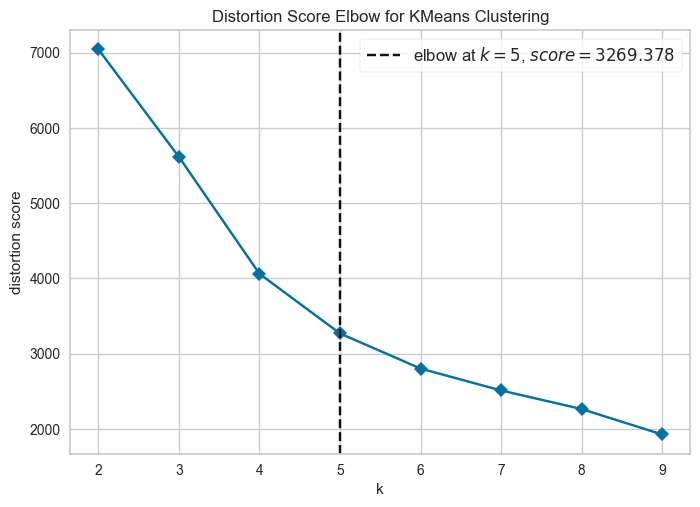

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
# Find Optimal K Using Elbow Method
model = KMeans(init="k-means++", random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='distortion', timings=False)
visualizer.fit(rfm_m_scaled)  # Fit the data
visualizer.show()

In [41]:
# Select the Optimal K (Based on Elbow Point)
optimal_k_m = visualizer.elbow_value_
print(f"Optimal Number of Clusters : {optimal_k_m}")

Optimal Number of Clusters : 5


In [42]:
# Apply K-Means with Optimal K
kmeans = KMeans(n_clusters=optimal_k_m, random_state=42)
rfm_m['Cluster'] = kmeans.fit_predict(rfm_m_scaled)

In [43]:
# Evaluate Clustering Performance
print(f"\033[4mEvaluation Metrics for m with K={optimal_k_m}:\033[0m")

silhouette_avg_m = silhouette_score(rfm_m_scaled, rfm_m['Cluster'])
print(f"Silhouette Score : {silhouette_avg_m:.4f}")

# Compute WCSS (Within-Cluster Sum of Squares)
WCSS_m = kmeans.inertia_
print(f"WCSS: {WCSS_m:.4f}")

# Compute Davies-Bouldin Index (DBI)
dbi_m = davies_bouldin_score(rfm_m_scaled, rfm_m['Cluster'])
print(f"Davies-Bouldin Index : {dbi_m:.4f}")

# Compute Calinski-Harabasz Index (CHI)
chi_m = calinski_harabasz_score(rfm_m_scaled, rfm_m['Cluster'])
print(f"Calinski-Harabasz Index : {chi_m:.4f}")

Evaluation Metrics for m with K=5:
Silhouette Score : 0.3923
WCSS: 3269.4055
Davies-Bouldin Index : 0.9762
Calinski-Harabasz Index : 48528.7702


In [44]:
# Group by clusters and calculate the mean RFM values for each cluster
cluster_means_m = rfm_m.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print("Mean RFM values for each cluster for M:")
print(cluster_means_m)

Mean RFM values for each cluster for M:
   Cluster   Recency  Frequency  Monetary
0        0  0.143590   0.135694  0.173950
1        1  0.189764   0.000000  0.094209
2        2  0.692499   0.001521  0.093042
3        3  0.535141   0.149699  0.212093
4        4  0.177094   0.315796  0.355929


In [45]:
# Define dynamic thresholds for segmentation (for rfm3m)
recency_threshold = rfm_m['Recency'].median()
frequency_threshold = rfm_m['Frequency'].median()
monetary_threshold = rfm_m['Monetary'].median()

# Assign segment labels based on cluster characteristics (for rfm3m)
def assign_cluster_label_minmax(cluster_id):
    recency = cluster_means_m.loc[cluster_means_m['Cluster'] == cluster_id, 'Recency'].values[0]
    frequency = cluster_means_m.loc[cluster_means_m['Cluster'] == cluster_id, 'Frequency'].values[0]
    monetary = cluster_means_m.loc[cluster_means_m['Cluster'] == cluster_id, 'Monetary'].values[0]
    
    # Define dynamic segment rules
    if recency < recency_threshold and frequency > frequency_threshold and monetary > monetary_threshold:
        return "Best Customers"
    elif recency > recency_threshold and frequency < frequency_threshold and monetary < monetary_threshold:
        return "Dormant Customers"
    elif recency < recency_threshold and frequency > frequency_threshold and monetary < monetary_threshold:
        return "Frequent Low-Spending"
    else:
        return "At-Risk Customers"


In [46]:
# Map the cluster labels dynamically for rfm3m
cluster_labels_m = {cluster: assign_cluster_label_minmax(cluster) for cluster in rfm_m['Cluster'].unique()}
rfm_m['Customer_Segment'] = rfm_m['Cluster'].map(cluster_labels_m)

# Display the assigned labels
print("\033[4mMin-Max Scaling Clustering\033[0m")
print(rfm_m[['Cluster', 'Customer_Segment']].drop_duplicates())

Min-Max Scaling Clustering
       Cluster   Customer_Segment
48893        2  Dormant Customers
41152        1  At-Risk Customers
43776        3  At-Risk Customers
19558        0     Best Customers
13780        4     Best Customers


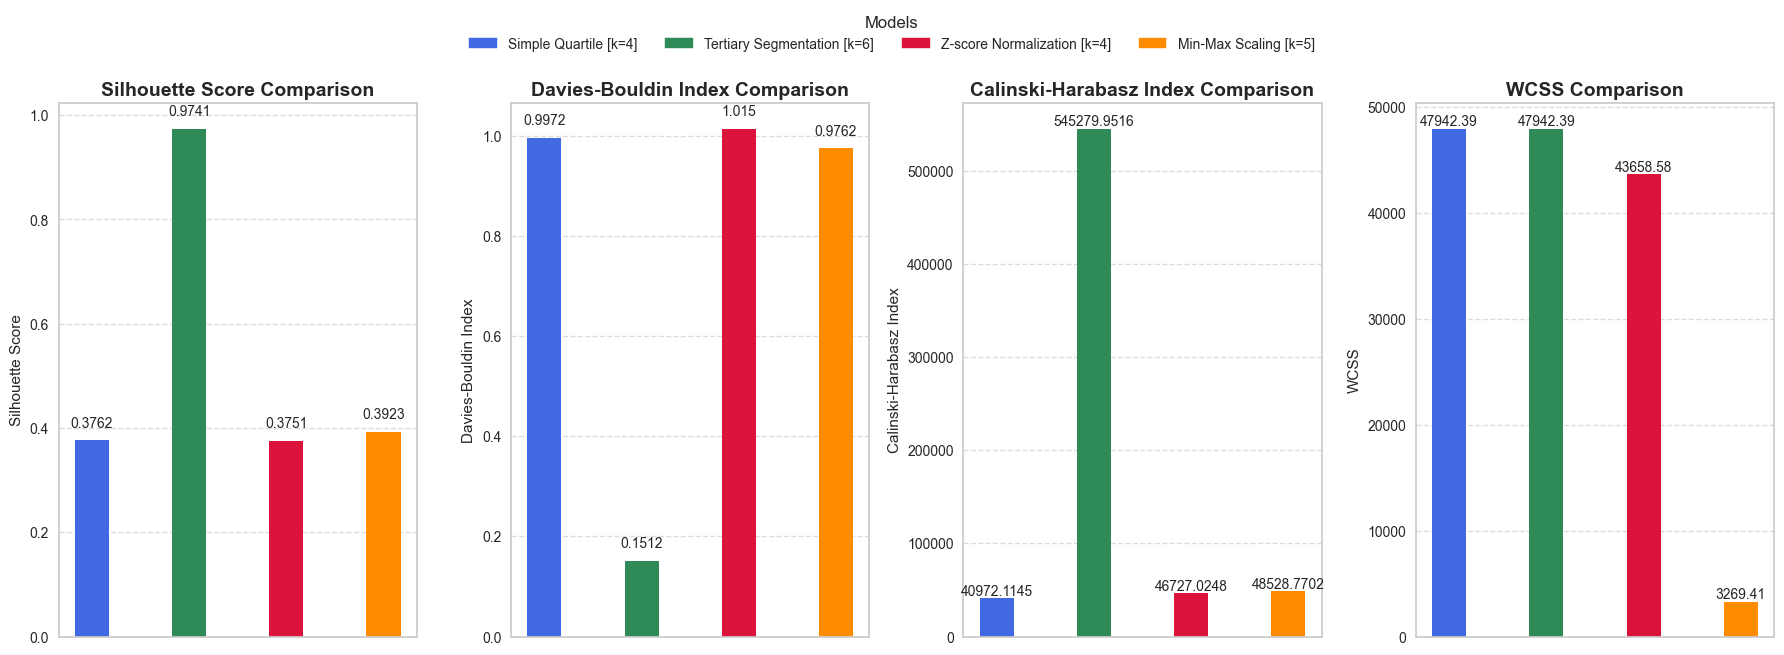

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Models
models = ["Simple Quartile", "Tertiary Segmentation", "Z-score Normalization", "Min-Max Scaling"]

# Metrics from your variables
silhouette_scores = [silhouette_avg_sqm, silhouette_avg_ts, silhouette_avg_z, silhouette_avg_m]
wcss_values = [WCSS_sqm, WCSS_ts, WCSS_z, WCSS_m]
dbi_values = [dbi_sqm, dbi_ts, dbi_z, dbi_m]
chi_values = [chi_sqm, chi_ts, chi_z, chi_m]
optimal_clusters = [optimal_k_sqm, optimal_k_ts, optimal_k_z, optimal_k_m]

# Create a DataFrame for easy visualization in table format
metrics_df = pd.DataFrame({
    "Model": models,
    "Optimal Clusters": optimal_clusters,
    "Silhouette Score": silhouette_scores,
    "WCSS": wcss_values,
    "Davies-Bouldin Index": dbi_values,
    "Calinski-Harabasz Index": chi_values,
    
})

# Set figure size (single row of 4 plots)
fig, axes = plt.subplots(1, 4, figsize=(18, 6))  # 1 row, 4 columns for subplots

# Bar width for better visualization
bar_width = 0.35

# Colors for different models
colors = ["royalblue", "seagreen", "crimson", "darkorange"]

# Bar Plot: Silhouette Score**
bars = axes[0].bar(models, silhouette_scores, color=colors, width=bar_width)
axes[0].set_title("Silhouette Score Comparison", fontsize=14, fontweight="bold")
axes[0].set_ylabel("Silhouette Score")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].set_xticks([])  # Remove model names from x-axis
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 4), ha="center", va="bottom", fontsize=10)

# Bar Plot: Davies-Bouldin Index**
bars = axes[1].bar(models, dbi_values, color=colors, width=bar_width)
axes[1].set_title("Davies-Bouldin Index Comparison", fontsize=14, fontweight="bold")
axes[1].set_ylabel("Davies-Bouldin Index")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].set_xticks([])  # Remove model names from x-axis
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 4), ha="center", va="bottom", fontsize=10)

# Bar Plot: Calinski-Harabasz Index**
bars = axes[2].bar(models, chi_values, color=colors, width=bar_width)
axes[2].set_title("Calinski-Harabasz Index Comparison", fontsize=14, fontweight="bold")
axes[2].set_ylabel("Calinski-Harabasz Index")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)
axes[2].set_xticks([])  # Remove model names from x-axis
for bar in bars:
    yval = bar.get_height()
    axes[2].text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 4), ha="center", va="bottom", fontsize=10)

# Bar Plot: WCSS**
bars = axes[3].bar(models, wcss_values, color=colors, width=bar_width)
axes[3].set_title("WCSS Comparison", fontsize=14, fontweight="bold")
axes[3].set_ylabel("WCSS")
axes[3].grid(axis="y", linestyle="--", alpha=0.7)
axes[3].set_xticks([])  # Remove model names from x-axis
for bar in bars:
    yval = bar.get_height()
    axes[3].text(bar.get_x() + bar.get_width() / 2, yval + 0.02, round(yval, 2), ha="center", va="bottom", fontsize=10)

# Adding a legend 
legend_labels = [f"{model} [k={k}]" for model, k in zip(models, optimal_clusters)]
fig.legend([mpatches.Patch(color=color) for color in colors], legend_labels, title="Models", bbox_to_anchor=(0.5, 1.05), loc="center", ncol=4)

# Adjust layout to ensure everything fits well
plt.tight_layout()
plt.show()


In [48]:
metrics_df

,Model,Optimal Clusters,Silhouette Score,WCSS,Davies-Bouldin Index,Calinski-Harabasz Index
0,Simple Quartile,4,0.376201,47942.385690,0.997186,40972.114492
1,Tertiary Segmentation,6,0.974123,47942.385690,0.151203,545279.951647
2,Z-score Normalization,4,0.375112,43658.577777,1.014960,46727.024758
3,Min-Max Scaling,5,0.392332,3269.405481,0.976217,48528.770176


In [49]:
# Assuming your DataFrames are df (main DataFrame) and rfm_ts (with Customer_Segment)
Segmented_Consolidated_df = df.merge(rfm_ts[['CustomerID', 'Customer_Segment']], on='CustomerID', how='left')

# Display the result
Segmented_Consolidated_df.head(5)

,CustomerID,ProductID,TransactionID,PurchaseAmount,PurchaseDate,PurchaseTime,PurchaseQuantity,CustomerName,Gender,Adress,...,RegistrationDate,CategoryID,Categories,Products,Prices,StockQuantity,FeedbackID,FeedbackDate,Ratings,Customer_Segment
0,CUSTIDXX-62149,PRODOXIID94,0,294,2023-06-20,2025-01-30T15:56:00.000Z,2,Kayla Torres,M,141 Nicole Circles Apt. 507,...,28-10-2021,CATOID00XX10,Pasta Rice and Grains,Lentils,1.30,75,FEDBXXID-0,12-03-2018,3,At-Risk Customers
1,CUSTIDXX-45943,PRODOXIID22,1,125,2019-09-03,2025-01-30T14:40:00.000Z,10,Brian Weiss,F,2510 Robert Garden Apt. 316,...,16-01-2024,CATOID00XX3,Meat and Seafood,Pork,6.00,1,FEDBXXID-1,26-09-2023,5,Dormant Customers
2,CUSTIDXX-52617,PRODOXIID42,2,828,2017-08-26,2025-01-30T12:34:00.000Z,7,Samantha Wagner,F,973 Perez Pass Suite 421,...,29-09-2022,CATOID00XX5,Frozen Foods,Frozen Meals,15.00,30,FEDBXXID-2,17-10-2022,5,Best Customers
3,CUSTIDXX-2768,PRODOXIID64,3,566,2023-01-25,2025-01-30T00:54:00.000Z,22,Karen Wise,F,87415 Hill Plaza,...,21-04-2017,CATOID00XX7,Snacks and Beverages,Nuts,8.98,53,FEDBXXID-3,05-12-2019,5,At-Risk Customers
4,CUSTIDXX-4036,PRODOXIID104,4,790,2023-04-19,2025-01-30T04:10:00.000Z,16,Tiffany Glover,M,67551 Pamela Rest Apt. 216,...,18-01-2018,CATOID00XX11,Baking Supplies,Vanilla Extract,1.29,52,FEDBXXID-4,16-04-2022,1,At-Risk Customers


In [50]:
rfm_ts.head(5)

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Cluster,Customer_Segment
0,CUSTIDXX-0,78,3,2991,2,2,2,3,Best Customers
1,CUSTIDXX-1,2024,1,32,1,1,1,2,Dormant Customers
2,CUSTIDXX-10,522,2,1925,2,1,2,4,At-Risk Customers
3,CUSTIDXX-100,235,4,4581,2,2,2,3,Best Customers
4,CUSTIDXX-10000,504,2,2313,2,1,2,4,At-Risk Customers
